# Saving and Loading Models

In this notebook, we'll see how to save and load models with TensorFlow. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.3.1
	• tf.keras version: 2.4.0
	• GPU device not found. Running on CPU


## Load the Dataset

In [5]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [6]:
# load data
dataset, info = tfds.load('beans', as_supervised=True, with_info=True, shuffle_files=True, split=['train', 'validation', 'test'])

# inspect dataset info
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

## Explore Dataset

In [7]:
num_training_ex = info.splits['train'].num_examples
num_validation_ex = info.splits['validation'].num_examples
num_test_ex = info.splits['test'].num_examples

print('Number of training examples:', num_training_ex)
print('Number of validation examples:', num_validation_ex)
print('Number of test examples:', num_test_ex)

image_shape = info.features['image'].shape
label_shape = info.features['label'].shape
num_classes = info.features['label'].num_classes

print('Images have shape:', image_shape)
print('Labels have shape:', label_shape)
print('There are {} number of classes.'.format(num_classes))

Number of training examples: 1034
Number of validation examples: 133
Number of test examples: 128
Images have shape: (500, 500, 3)
Labels have shape: ()
There are 3 number of classes.


## Build Pipeline

In [8]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

training_set, validation_set, test_set = dataset

batch_size = 32

training_batches = training_set.cache().shuffle(num_training_ex // 4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
test_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

class_names = ['Angular Leaf Spot', 'Bean Rust', 'Healthy']

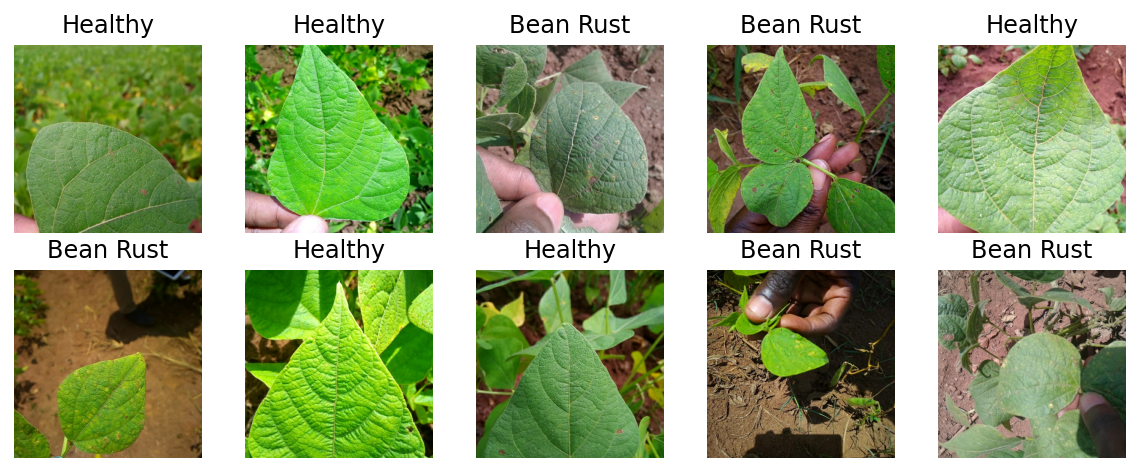

In [9]:
# have a quick look at the images and labels
for images, labels in training_batches.take(1):
    images = images.numpy().squeeze()
    labels = labels.numpy()

plt.figure(figsize=(10,10))
for n in range(10):
    plt.subplot(5,5,n+1)
    plt.imshow(images[n], cmap=plt.cm.binary)
    plt.title(class_names[labels[n]])
    plt.axis('off')


## Build the Model 

In [10]:
dropout_rate = 0.2

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(500,500,3), name='input'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax', name='output'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 750000)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               192000256 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 3)                 99        
Total params: 192,043,587
Trainable params: 192,043,587
Non-trainable params: 0
__________________________________________

In [11]:
lr = 0.001
epochs = 20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(training_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/20
33/33 [==============================] - 23s 702ms/step - loss: 106.1628 - accuracy: 0.3356 - val_loss: 24.9709 - val_accuracy: 0.3835
Epoch 2/20
33/33 [==============================] - 22s 661ms/step - loss: 16.6732 - accuracy: 0.5068 - val_loss: 15.2903 - val_accuracy: 0.4511
Epoch 3/20
33/33 [==============================] - 24s 720ms/step - loss: 17.0709 - accuracy: 0.5213 - val_loss: 43.6981 - val_accuracy: 0.3684
Epoch 4/20
33/33 [==============================] - 25s 756ms/step - loss: 17.2189 - accuracy: 0.5397 - val_loss: 9.5919 - val_accuracy: 0.6090
Epoch 5/20
33/33 [==============================] - 23s 705ms/step - loss: 11.4228 - accuracy: 0.5890 - val_loss: 6.4359 - val_accuracy: 0.5940
Epoch 6/20
33/33 [==============================] - 28s 852ms/step - loss: 13.5908 - accuracy: 0.5058 - val_loss: 3.5896 - val_accuracy: 0.7068
Epoch 7/20
33/33 [==============================] - 23s 709ms/step - loss: 5.0741 - accuracy: 0.6460 - val_loss: 15.2212 - val_accur

Text(0.5, 1.0, 'Training and Validation Loss')

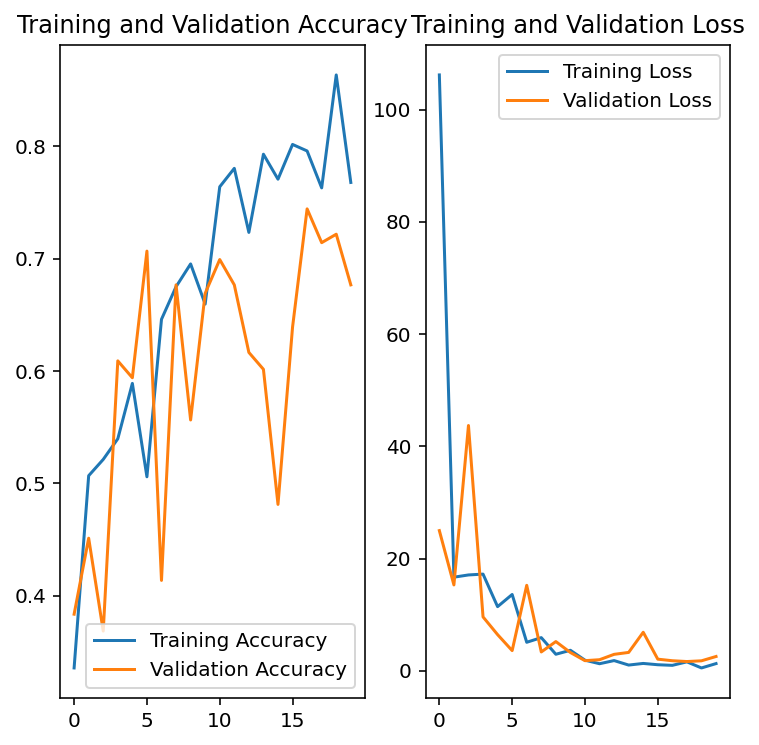

In [12]:
loss, accuracy, val_loss, val_accuracy = [history.history[k] for k in ('loss', 'accuracy', 'val_loss', 'val_accuracy')]

epoch_range = range(len(accuracy))

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [13]:
loss, accuracy = model.evaluate(test_batches)

print('The model has a loss of: {:,.3f}'.format(loss))
print('The model has an accuracy of: {:,.3%}'.format(accuracy))

4/4 [==============================] - 0s 112ms/step - loss: 2.0618 - accuracy: 0.6484
The model has a loss of: 2.062
The model has an accuracy of: 64.844%


## Saving and Loading Models

In TensorFlow we can save our trained models in different formats. Here we will see how to save our models in TensorFlow's SavedModel format and as HDF5 files, which is the format used by Keras models.

### Saving and Loading Models in HDF5 Format

To save our models in the format used by Keras models we use the `.save(filepath)` method. For example, to save a model called `my_model` in the current working directory with the name `test_model` we use:

```python
my_model.save('./test_model.h5')
```

It's important to note that we have to provide the `.h5` extension to the `filepath` in order the tell `tf.keras` to save our model as an HDF5 file. 

The above command saves our model into a single HDF5 file that will contain:

* The model's architecture.
* The model's weight values which were learned during training.
* The model's training configuration, which corresponds to the parameters you passed to the `compile` method.
* The optimizer and its state. This allows you to resume training exactly where you left off.


In the cell below we save our trained `model` as an HDF5 file. The name of our HDF5 will correspond to the current time stamp. This is useful if you are saving many models and want each of them to have a unique name. By default the `.save()` method will **silently** overwrite any existing file at the target location with the same name. If we want `tf.keras` to provide us with a manual prompt to whether overwrite files with the same name, you can set the argument `overwrite=False` in the `.save()` method.

In [14]:
model_name = model.name

saved_keras_model_filepath = './models/{}.h5'.format(model_name)
model.save(saved_keras_model_filepath, overwrite=False)


Once a model has been saved, we can use `tf.keras.models.load_model(filepath)` to re-load our model. This command will also compile our model automatically using the saved training configuration, unless the model was never compiled in the first place.

In [15]:
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath)

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 750000)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               192000256 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 3)                 99        
Total params: 192,043,587
Trainable params: 192,043,587
Non-trainable params: 0
__________________________________________

In [16]:
# check if the original model and reloaded model make the same prediction
for image_batch, label_batch in test_batches.take(1):
    pred_1 = model.predict(image_batch)
    pred_2 = reloaded_keras_model.predict(image_batch)
    diff = np.abs(pred_1 - pred_2)
    print(diff.max())

0.0


## Saving and Loading Tensorflow SavedModels

To export our models to the TensorFlow **SavedModel** format, we use the `tf.saved_model.save(model, export_dir)` function. For example, to save a model called `my_model` in a folder called `saved_models` located in the current working directory we use:

```python
tf.saved_model.save(my_model, './saved_models')
```

It's important to note that here we have to provide the path to the directory where we want to save our model, **NOT** the name of the file. This is because SavedModels are not saved in a single file. Rather, when you save your model as a SavedModel, `the tf.saved_model.save()` function will create an `assets` folder, a `variables` folder, and a `saved_model.pb` file inside the directory you provided.

The SavedModel files that are created contain:

* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying TensorFlow graph. Separate graphs are saved for prediction (serving), training, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture configuration if available.

The SavedModel is a standalone serialization format for TensorFlow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. It does not require the original model building code to run, which makes it useful for sharing or deploying in different platforms, such as mobile and embedded devices (with TensorFlow Lite), servers (with TensorFlow Serving), and even web browsers (with TensorFlow.js).

In the cell below we save our trained model as a SavedModel. The name of the folder where we are going to save our model will correspond to the current time stamp. Again, this is useful if you are saving many models and want each of them to be saved in a unique directory.

In [17]:
savedModel_directory = './models/{}'.format(model_name)
tf.saved_model.save(model, savedModel_directory)


In [18]:
# reload model from savedModel
reloaded_savedModel = tf.saved_model.load(savedModel_directory)


It's important to note that the object returned by `tf.saved_model.load` is **NOT** a Keras object. Therefore, it doesn't have `.fit`, `.predict`, `.summary`, etc. methods. It is 100% independent of the code that created it. This means that in order to make predictions with our `reloaded_SavedModel` we need to use a different method than the one used with the re-loaded Keras model.

To make predictions on a batch of images with a re-loaded SavedModel we have to use:

```python
reloaded_SavedModel(image_batch, training=False)
```

This will return a tensor with the predicted label probabilities for each image in the batch. Again, since we haven't done anything new to this re-loaded SavedModel, then both the `reloaded_SavedModel` and our original `model` should be identical copies. Therefore, they should make the same predictions on the same images. Let's check that this is true:

In [19]:
for image_batch, label_batch in test_batches.take(1):
    pred_1 = model.predict(image_batch)
    pred_2 = reloaded_savedModel(image_batch, training=False).numpy()
    diff = np.abs(pred_1 - pred_2)
    print(diff.max())

0.0


In [20]:
reloaded_keras_model_from_savedModel = tf.keras.models.load_model(savedModel_directory)

reloaded_keras_model_from_savedModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 750000)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               192000256 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 3)                 99        
Total params: 192,043,587
Trainable params: 192,043,587
Non-trainable params: 0
__________________________________________

## Saving Models During Training

We have seen that when we train a model with a validation set, the value of the validation loss changes through the training process. Since the value of the validation loss is an indicator of how well our model will generalize to new data, it will be great if could save our model at each step of the training process and then only keep the version with the lowest validation loss. 

We can do this in `tf.keras` by using the following callback:

```python
tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='val_loss', save_best_only=True)
```
This callback will save the model as a Keras HDF5 file after every epoch. With the `save_best_only=True` argument, this callback will first check the validation loss of the latest model against the one previously saved. The callback will only save the latest model and overwrite the old one, if the latest model has a lower validation loss than the one previously saved. This will guarantee that will end up with the version of the model that achieved the lowest validation loss during training.

In [21]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(500,500,3), name='input'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax', name='output')
])

my_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

save_best = tf.keras.callbacks.ModelCheckpoint('./models/best_model.h5', monitor='val_loss', save_best_only=True)

my_history = my_model.fit(training_batches, epochs=epochs, validation_data=validation_batches, callbacks=[early_stopping, save_best])


Epoch 1/20
33/33 [==============================] - 32s 973ms/step - loss: 43.7994 - accuracy: 0.3617 - val_loss: 7.2757 - val_accuracy: 0.4737
Epoch 2/20
33/33 [==============================] - 23s 683ms/step - loss: 8.0670 - accuracy: 0.4729 - val_loss: 7.4569 - val_accuracy: 0.3910
Epoch 3/20
33/33 [==============================] - 28s 850ms/step - loss: 5.0996 - accuracy: 0.5048 - val_loss: 5.1236 - val_accuracy: 0.4662
Epoch 4/20
33/33 [==============================] - 27s 819ms/step - loss: 3.1606 - accuracy: 0.5861 - val_loss: 3.8302 - val_accuracy: 0.4586
Epoch 5/20
33/33 [==============================] - 27s 817ms/step - loss: 2.2586 - accuracy: 0.6112 - val_loss: 1.7205 - val_accuracy: 0.6391
Epoch 6/20
33/33 [==============================] - 22s 654ms/step - loss: 5.6762 - accuracy: 0.5048 - val_loss: 6.9503 - val_accuracy: 0.4436
Epoch 7/20
33/33 [==============================] - 22s 661ms/step - loss: 3.0747 - accuracy: 0.6044 - val_loss: 7.6933 - val_accuracy: 0.413